In [118]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score,calinski_harabasz_score


## Attributes for determining a customer into a cluster
####    -Recency(Time (in days) since last transaction)
####    -Frequency(No of transactions)
####    -Monetary Value(Total money spent)
####    -Region
####    -Tenure(No of days since the customer signed up)
####    -Average order value
####    -Transaction Diversity(no of differient products bought)

## Data loading

In [128]:
customers = pd.read_csv("Customers.csv")
transactions = pd.read_csv("Transactions.csv")


In [129]:
transactions.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68


In [130]:
customers.head()

,CustomerID,CustomerName,Region,SignupDate
0,C0001,Lawrence Carroll,South America,2022-07-10
1,C0002,Elizabeth Lutz,Asia,2022-02-13
2,C0003,Michael Rivera,South America,2024-03-07
3,C0004,Kathleen Rodriguez,South America,2022-10-09
4,C0005,Laura Weber,Asia,2022-08-15


In [131]:
data = customers.merge(transactions, on='CustomerID')


In [138]:
data['SignupDate'] = pd.to_datetime(data['SignupDate'])
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])

In [135]:
data.head()

,CustomerID,CustomerName,Region,SignupDate,TransactionID,ProductID,TransactionDate,Quantity,TotalValue,Price
0,C0001,Lawrence Carroll,South America,2022-07-10,T00015,P054,2024-01-19 03:12:55,2,114.60,57.30
1,C0001,Lawrence Carroll,South America,2022-07-10,T00932,P022,2024-09-17 09:01:18,3,412.62,137.54
2,C0001,Lawrence Carroll,South America,2022-07-10,T00085,P096,2024-04-08 00:01:00,2,614.94,307.47
3,C0001,Lawrence Carroll,South America,2022-07-10,T00445,P083,2024-05-07 03:11:44,2,911.44,455.72
4,C0001,Lawrence Carroll,South America,2022-07-10,T00436,P029,2024-11-02 17:04:16,3,1300.92,433.64


# Data Pre Processing

In [145]:
customer_data = data.groupby('CustomerID').agg(
    DifferentProducts = ('ProductID',pd.Series.nunique),
    Frequency=('TransactionID',pd.Series.nunique),
    TotalSpent=('TotalValue','sum'),
    Region=('Region','first'),
    LastTransaction=('TransactionDate','max'),
).reset_index()

customer_data['AverageOrderValue'] = customer_data['TotalSpent'] / customer_data['Frequency']
tenure_data = (pd.Timestamp.now() - data.groupby('CustomerID')['SignupDate'].first()).dt.days.reset_index()
tenure_data.columns = ['CustomerID', 'Tenure']
customer_data = pd.merge(customer_data, tenure_data, on='CustomerID')

In [146]:
customer_data['Regency'] = (pd.Timestamp.now()-customer_data['LastTransaction']).dt.days
customer_data.drop('LastTransaction',axis = 1,inplace=True)

In [147]:
customer_data.head()

,CustomerID,DifferentProducts,Frequency,TotalSpent,Region,AverageOrderValue,Tenure,Regency
0,C0001,5,5,3354.52,South America,670.904,936,90
1,C0002,4,4,1862.74,Asia,465.685,1083,59
2,C0003,4,4,2725.38,South America,681.345,330,160
3,C0004,8,8,5354.88,South America,669.360,845,39
4,C0005,3,3,2034.24,Asia,678.080,900,88


In [148]:
#Encoding the Region
encoder = OneHotEncoder(sparse_output=False)
values = encoder.fit_transform(customer_data[['Region']])
encoded_df = pd.DataFrame(values,columns=encoder.get_feature_names_out(['Region']))
customer_data = pd.concat([customer_data.drop('Region',axis=1), encoded_df],axis = 1)

In [149]:
customer_data.head()


,CustomerID,DifferentProducts,Frequency,TotalSpent,AverageOrderValue,Tenure,Regency,Region_Asia,Region_Europe,Region_North America,Region_South America
0,C0001,5,5,3354.52,670.904,936,90,0.0,0.0,0.0,1.0
1,C0002,4,4,1862.74,465.685,1083,59,1.0,0.0,0.0,0.0
2,C0003,4,4,2725.38,681.345,330,160,0.0,0.0,0.0,1.0
3,C0004,8,8,5354.88,669.360,845,39,0.0,0.0,0.0,1.0
4,C0005,3,3,2034.24,678.080,900,88,1.0,0.0,0.0,0.0


In [150]:
customer_data.describe()

,DifferentProducts,Frequency,TotalSpent,AverageOrderValue,Tenure,Regency,Region_Asia,Region_Europe,Region_North America,Region_South America
count,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000,199.000000
mean,4.894472,5.025126,3467.314372,687.580182,562.135678,108.321608,0.221106,0.251256,0.231156,0.296482
std,2.113908,2.198340,1832.677958,237.936649,326.273413,70.933723,0.416038,0.434830,0.422635,0.457858
min,1.000000,1.000000,82.360000,82.360000,34.000000,34.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,3.000000,2162.040000,542.941667,293.000000,51.500000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,5.000000,3137.660000,677.207500,531.000000,93.000000,0.000000,0.000000,0.000000,0.000000
75%,6.000000,6.000000,4770.225000,828.624167,859.000000,138.000000,0.000000,0.500000,0.000000,1.000000
max,10.000000,11.000000,10673.870000,1323.133333,1105.000000,395.000000,1.000000,1.000000,1.000000,1.000000


## Scaling the data

In [151]:
features = customer_data.drop(['CustomerID'],axis=1)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

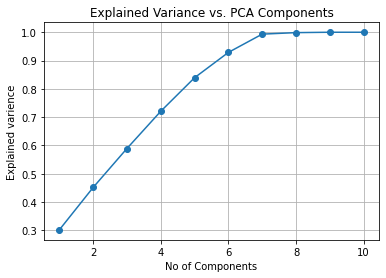

In [152]:
pca = PCA().fit(scaled_features)
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel("No of Components")
plt.ylabel("Explained varience")
plt.title("Explained Variance vs. PCA Components")
plt.grid(True)
plt.show()


## Performing PCA combined with k mean clustering

# K Mean clustering

In [153]:
optml_pca = 0
optml_k = 0 
prev = 0
for i in range(1,8):
    db_values= []
    pca = PCA(n_components=i)
    features_reduction = pca.fit_transform(scaled_features)
    for k in range(2, 11):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(features_reduction)
        db_values.append(davies_bouldin_score(scaled_features, labels))
    print(db_values)
    k = np.argmin(db_values) + 2
    print(np.argmin(db_values))
    print("Optimal number of clusters: "+str(k))
    db_min = min(db_values)
    prev = min(db_min,prev)
    if prev != db_min:
        optml_k = k
        optml_pca = i
print("optimal pca compnents is :: ",optml_pca)
print("optimal no of clusters is :: ",optml_k)

[2.032098893864444, 2.400308138823806, 2.729612473107023, 3.360973541120905, 3.5656204293033595, 3.5636348227277392, 4.053700887592132, 4.080730456094659, 3.8991398462617703]
0
Optimal number of clusters: 2
[2.0283610217926946, 1.8319016011835618, 1.9591302299331002, 2.0197553710316543, 2.2200856705210152, 2.0173877602123147, 1.837465255510869, 2.350171816969126, 2.178418295522111]
1
Optimal number of clusters: 3
[2.0106440260994902, 2.264244782553448, 1.9113228362227543, 1.6371766704092359, 1.9555697204904936, 1.8420852567360768, 1.9424302543200431, 1.9221289719612347, 1.9396109770400116]
3
Optimal number of clusters: 5
[2.0106440260994902, 1.7848811107574047, 1.610468997249049, 1.3090072086479576, 1.324632511869899, 1.3638587670516829, 1.230187256978247, 1.1984219289862446, 1.2938884576193257]
7
Optimal number of clusters: 9
[2.0106440260994902, 2.0329800959937945, 1.6342395475390203, 1.6452657649321414, 1.3056768345119885, 1.2799444562343016, 1.2776276579217405, 1.2902192577386749, 

In [154]:
pca = PCA(n_components=optml_pca)
features_reduction = pca.fit_transform(scaled_features)
kmeans = KMeans(n_clusters=optml_k, random_state=42)
customer_data['Cluster'] = kmeans.fit_predict(features_reduction)

In [155]:
customer_data.head()

,CustomerID,DifferentProducts,Frequency,TotalSpent,AverageOrderValue,Tenure,Regency,Region_Asia,Region_Europe,Region_North America,Region_South America,Cluster
0,C0001,5,5,3354.52,670.904,936,90,0.0,0.0,0.0,1.0,1
1,C0002,4,4,1862.74,465.685,1083,59,1.0,0.0,0.0,0.0,3
2,C0003,4,4,2725.38,681.345,330,160,0.0,0.0,0.0,1.0,1
3,C0004,8,8,5354.88,669.360,845,39,0.0,0.0,0.0,1.0,1
4,C0005,3,3,2034.24,678.080,900,88,1.0,0.0,0.0,0.0,3


# Evaluation of the clusters 

In [156]:
# Cluster Evaluation using DB Index, silhouette score, calinski-harabasz index
db_index = davies_bouldin_score(scaled_features, customer_data['Cluster'])
silhouette = silhouette_score(scaled_features, customer_data['Cluster'])
ch_index = calinski_harabasz_score(scaled_features,customer_data['Cluster'])

print(f"Davies-Bouldin Index: {db_index}")
print(f"Silhouette Score: {silhouette}")
print(f"ch_index :: {ch_index}")


Davies-Bouldin Index: 1.1594972352893198
Silhouette Score: 0.3101970647277178
ch_index :: 46.23813340060166


# Visualization

### Performing PCA for visualization

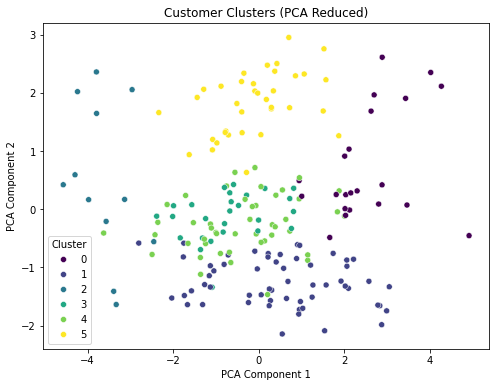

In [157]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(scaled_features)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=customer_data['Cluster'], palette='viridis')
plt.title('Customer Clusters (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()